# Info
Purpose:

    Describe the details ...

Input:

    arguments

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - file.rc : for consistent creation of look of matplotlib figures
  - ...

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2021-06-01
    Modified:


# Prepare python environment

In [1]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os


In [2]:
from scipy.interpolate import UnivariateSpline

In [3]:
name = 'FOG2FIRE'
vv = 'v1'
fp = getpath(name)


Return path named:  FOG2FIRE /data/sam/FOG2FIRE/


# Load files

In [4]:
f = os.listdir(fp)
f.sort()
f

['MYD06',
 'MYD06_2003_v1.npy',
 'MYD06_2004_v1.npy',
 'MYD06_2005_v1.npy',
 'MYD06_2007_v1.npy',
 'MYD06_2008_v1.npy',
 'MYD06_2013_v1.npy',
 'MYD06_2014_v1.npy',
 'MYD06_2015_v1.npy',
 'MYD06_2016_v1.npy',
 'MYD06_2017_v1.npy',
 'MYD06_2018_v1.npy',
 'MYD06_2020_v1.npy',
 'MYD06_v1.npy',
 'MYD14',
 'MYD14_2002_v1.npy',
 'MYD14_2002_v2.npy',
 'MYD14_2003_v1.npy',
 'MYD14_2003_v2.npy',
 'MYD14_2004_v1.npy',
 'MYD14_2004_v2.npy',
 'MYD14_2005_v1.npy',
 'MYD14_2005_v2.npy',
 'MYD14_2006_v1.npy',
 'MYD14_2006_v2.npy',
 'MYD14_2007_v1.npy',
 'MYD14_2007_v2.npy',
 'MYD14_2008_v1.npy',
 'MYD14_2008_v2.npy',
 'MYD14_2009_v1.npy',
 'MYD14_2009_v2.npy',
 'MYD14_2010_v1.npy',
 'MYD14_2010_v2.npy',
 'MYD14_2011_v1.npy',
 'MYD14_2011_v2.npy',
 'MYD14_2012_v1.npy',
 'MYD14_2012_v2.npy',
 'MYD14_2013_v1.npy',
 'MYD14_2013_v2.npy',
 'MYD14_2014_v1.npy',
 'MYD14_2014_v2.npy',
 'MYD14_2015_v1.npy',
 'MYD14_2015_v2.npy',
 'MYD14_2016_v1.npy',
 'MYD14_2016_v2.npy',
 'MYD14_2017_v1.npy',
 'MYD14_2017_v2.n

In [5]:
years = ['2002','2003','2004','2005','2006','2007','2008','2009',
         '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']

## Load the clouds

In [6]:
cld = []
for y in years:
    try:
        c = np.load(fp+'MYD06_{}_{}.npy'.format(y,vv),allow_pickle=True,fix_imports=True,encoding='latin1')
        c = c.item()
    except FileNotFoundError:
        c = {}
    cld.append(c)

In [7]:
cld[1].keys()

dict_keys(['sza', 'CF', 'regions', 'cld_top', 'time', 'surf_temp', 'lbls_rg'])

## Load the fire counts

In [8]:
fir = []
for y in years:
    try:
        i = np.load(fp+'MYD14_{}_{}.npy'.format(y,vv),allow_pickle=True,fix_imports=True,encoding='latin1')
        i = i.item()
    except FileNotFoundError:
        i = {}
    fir.append(i)

In [9]:
fir[1].keys()

dict_keys(['FP', 'regions', 'lbls_rg', 'time'])

# Plot out data

In [78]:
cld[1]['CF'].keys()

dict_keys(['coast', 'land', 'ocean'])

In [79]:
cld[1]['CF']['coast'].keys()

dict_keys(['std', 'num', 'median', 'mean', 'dev'])

In [80]:
cld[1]['CF']['coast']['mean'].shape

(500, 4)

## Make smoothing and plotting functions

In [13]:
def smooth(x,y,w):
    y = np.array(y)
    x = np.array(x)
    igood = np.isfinite(y)
    fx = UnivariateSpline(x[igood],y[igood],w=w[igood]/max(w),s=104,k=3)
    return fx(x)

In [14]:
from scipy.signal import savgol_filter

In [15]:
import statsmodels.api as sm

In [16]:
def smooth_l(x,y,w):
    y = np.array(y)
    x = np.array(x)
    igood = np.isfinite(y)
    fx = sm.nonparametric.lowess(y[igood],x[igood],frac=0.1)
    return fx[:,0],fx[:,1]

In [17]:
def non_uniform_savgol(x, y, window, polynom):
    """
    Applies a Savitzky-Golay filter to y with non-uniform spacing
    as defined in x

    This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
    The borders are interpolated like scipy.signal.savgol_filter would do

    Parameters
    ----------
    x : array_like
        List of floats representing the x values of the data
    y : array_like
        List of floats representing the y values. Must have same length
        as x
    window : int (odd)
        Window length of datapoints. Must be odd and smaller than x
    polynom : int
        The order of polynom used. Must be smaller than the window size

    Returns
    -------
    np.array of float
        The smoothed y values
    """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))     # Matrix
    tA = np.empty((polynom, window))    # Transposed matrix
    t = np.empty(window)                # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

In [18]:
def gaussian_sum_smooth(xdata, ydata, xeval, sigma, null_thresh=0.6):
    """Apply gaussian sum filter to data.

    xdata, ydata : array
        Arrays of x- and y-coordinates of data. 
        Must be 1d and have the same length.

    xeval : array
        Array of x-coordinates at which to evaluate the smoothed result

    sigma : float
        Standard deviation of the Gaussian to apply to each data point
        Larger values yield a smoother curve.

    null_thresh : float
        For evaluation points far from data points, the estimate will be
        based on very little data. If the total weight is below this threshold,
        return np.nan at this location. Zero means always return an estimate.
        The default of 0.6 corresponds to approximately one sigma away 
        from the nearest datapoint.
    """
    # Distance between every combination of xdata and xeval
    # each row corresponds to a value in xeval
    # each col corresponds to a value in xdata
    delta_x = xeval[:, None] - xdata

    # Calculate weight of every value in delta_x using Gaussian
    # Maximum weight is 1.0 where delta_x is 0
    weights = np.exp(-0.5 * ((delta_x / sigma) ** 2))

    # Multiply each weight by every data point, and sum over data points
    smoothed = np.dot(weights, ydata)

    # Nullify the result when the total weight is below threshold
    # This happens at evaluation points far from any data
    # 1-sigma away from a data point has a weight of ~0.6
    nan_mask = weights.sum(1) < .6
    smoothed[nan_mask] = np.nan

    # Normalize by dividing by the total weight at each evaluation point
    # Nullification above avoids divide by zero warning shere
    smoothed = smoothed / weights.sum(1)


    return smoothed

In [19]:
def smooth_s(x,y,w=25,p=4):
    y = np.array(y)
    x = np.array(x)
    igood = np.isfinite(y)
    if len(y[igood])<w:
        yp = y[igood]+np.nan
    else:
        yp = non_uniform_savgol(x[igood],y[igood],w,p)
    return x[igood],yp

In [20]:
def smooth_g(x,y,s=0.1):
    y = np.array(y)
    x = np.array(x)
    igood = np.isfinite(y)
    yp = gaussian_sum_smooth(x[igood],y[igood],x[igood],s)
    return x[igood],yp

In [21]:
cld[i]['time'][0].minute

TypeError: list indices must be integers or slices, not dict

## Plot out the CF time series

In [22]:
for j in range(4):
    for i,yy in enumerate(years):
        if cld[i]:
            for c in cld[i]['CF'].keys():
                if not 'dev' in  cld[i]['CF'][c]:
                    cld[i]['CF'][c]['dev'] = np.zeros_like(cld[i]['CF'][c]['mean']) 
                cld[i]['CF'][c]['dev'][:,j] = np.nancumsum(cld[i]['CF'][c]['mean'][:,j]-np.nanmean(cld[i]['CF'][c]['mean'][:,j]))

<IPython.core.display.Javascript object>


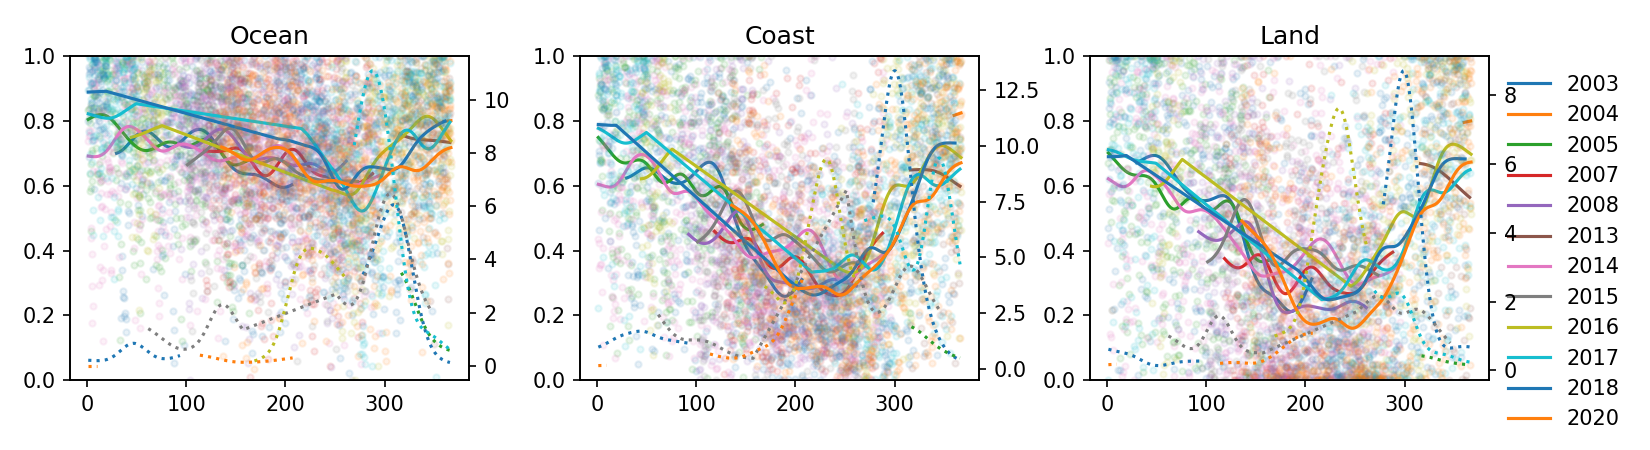

<IPython.core.display.Javascript object>


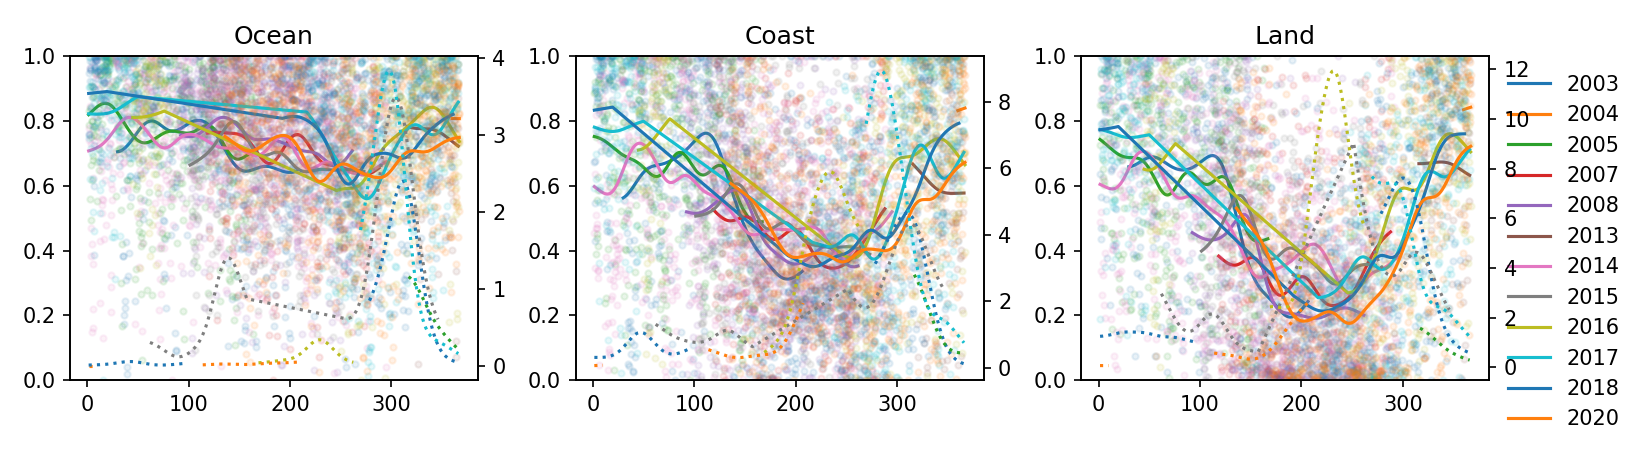

<IPython.core.display.Javascript object>


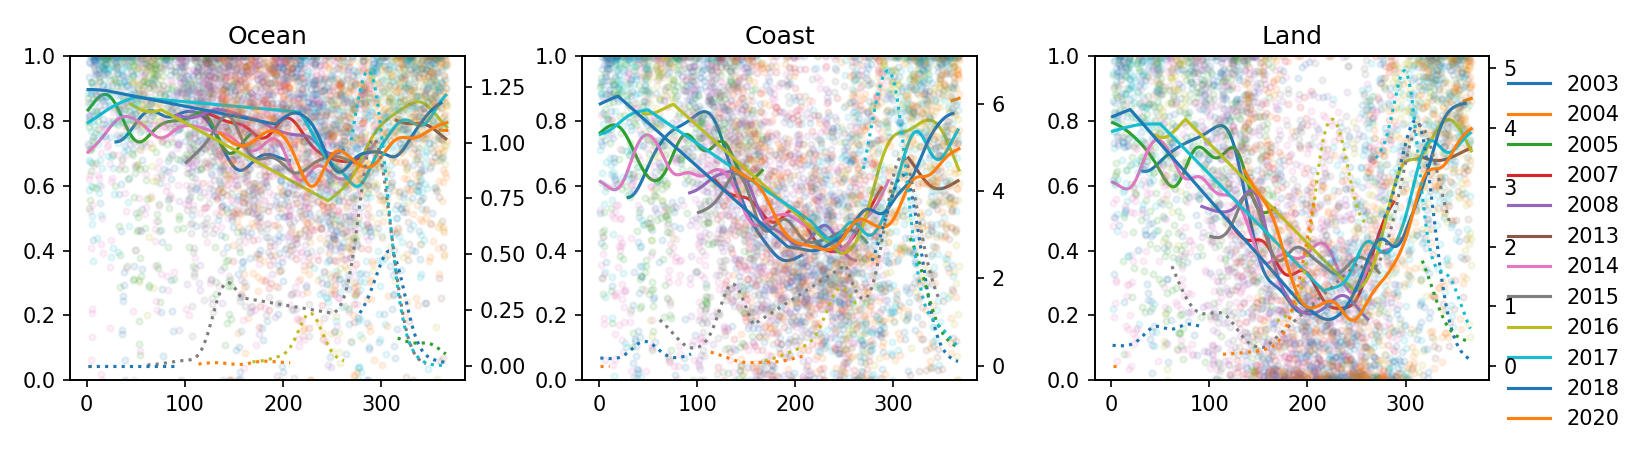

<IPython.core.display.Javascript object>


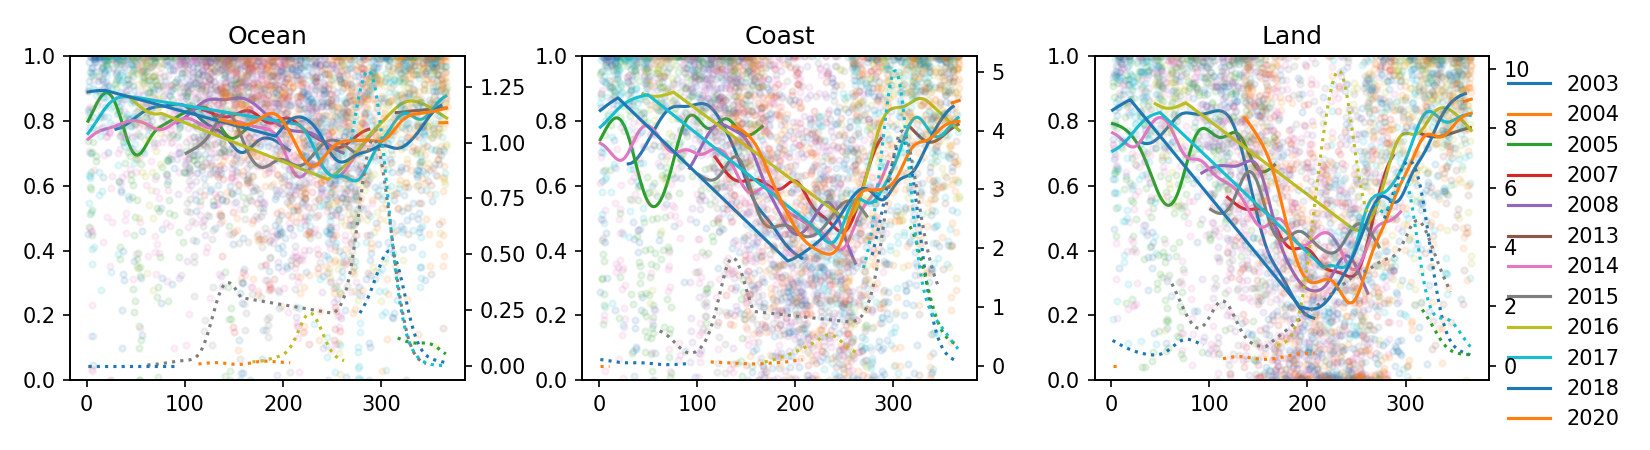

In [23]:
for j in range(4):

    fig, ax = plt.subplots(1,3,figsize=(11,3))
    axx = [axs.twinx() for axs in ax]
    for i,yy in enumerate(years):
        if cld[i]:
            doy = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in cld[i]['time']]

            p = ax[0].plot(doy,cld[i]['CF']['ocean']['mean'][:,j],'.',alpha=0.1)
            #x,y = savgol_filter((doy,cld[i]['CF']['coast']['mean'][:,0]),25,3)
            #x,y = smooth_l(doy,cld[i]['CF']['coast']['mean'][:,0],1)
            #x,y = smooth_s(doy,cld[i]['CF']['coast']['mean'][:,0],w=125,p=3)
            x,y = smooth_g(doy,cld[i]['CF']['ocean']['mean'][:,j],s=12.0)
            ax[0].plot(x,y,'-',c=p[0].get_color(),label=yy)

            ax[1].plot(doy,cld[i]['CF']['coast']['mean'][:,j],'.',alpha=0.1,c=p[0].get_color())
            x,y = smooth_g(doy,cld[i]['CF']['coast']['mean'][:,j],s=12.0)
            ax[1].plot(x,y,'-',c=p[0].get_color(),label=yy)

            ax[2].plot(doy,cld[i]['CF']['land']['mean'][:,j],'.',alpha=0.1,c=p[0].get_color())
            x,y = smooth_g(doy,cld[i]['CF']['land']['mean'][:,j],s=12.0)
            ax[2].plot(x,y,'-',c=p[0].get_color(),label=yy)

            if fir[i]:
                doyf = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in fir[i]['time']]
                #axx[0].plot(doyf,fir[i]['FP']['ocean']['num'][:,0],'+',alpha=0.1,c=p[0].get_color())
                x,y = smooth_g(doyf,fir[i]['FP']['ocean']['num'][:,j],s=12.0)
                axx[0].plot(x,y,':',c=p[0].get_color())
                x,y = smooth_g(doyf,fir[i]['FP']['coast']['num'][:,j],s=12.0)
                axx[1].plot(x,y,':',c=p[0].get_color())
                x,y = smooth_g(doyf,fir[i]['FP']['land']['num'][:,j],s=12.0)
                axx[2].plot(x,y,':',c=p[0].get_color())

    nul = [axs.set_ylim([0,1]) for axs in ax]
    ax[2].legend(frameon=False,bbox_to_anchor=(1.0,1.0) )
    ax[0].set_title('Ocean')
    ax[1].set_title('Coast')
    ax[2].set_title('Land')
    plt.tight_layout()

## CF Histogram for each region

In [120]:
txts = ['Oregon','NorCal','Central','SoCal']

In [105]:
cf = {}
for u in ['ocean','coast','land']:
    cf[u] = [[],[],[],[]]

In [106]:
for u in ['ocean','coast','land']:
    for j in range(4): 
        for i,yy in enumerate(years):
            if cld[i]:
                cf[u][j].append(cld[i]['CF'][u]['mean'][:,j])
        cf[u][j] = np.hstack(cf[u][j])

<IPython.core.display.Javascript object>


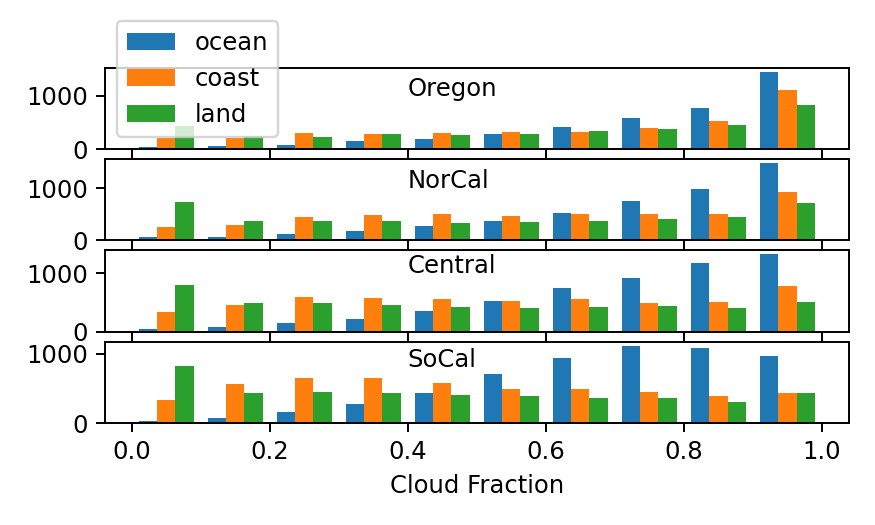

In [142]:
fig,axs = plt.subplots(4,1,sharex=True,figsize=(5,3))

for j,ax in enumerate(axs): 
    ax.hist([cf['ocean'][3-j],cf['coast'][3-j],cf['land'][3-j]],label=['ocean','coast','land'])
    if j==0: ax.legend(frameon=True)
    if j==3: 
        ax.set_xlabel('Cloud Fraction')
    if j==3: 
        ax.text(0.4,800,txts[j])
    else:
        ax.text(0.4,1000,txts[j])
plt.tight_layout(h_pad=-0.2)
plt.savefig(fp+'FOG2FIRE_CF_histogram.png',dpi=600,transparent=True)

## Time series of CF and fire count

<IPython.core.display.Javascript object>


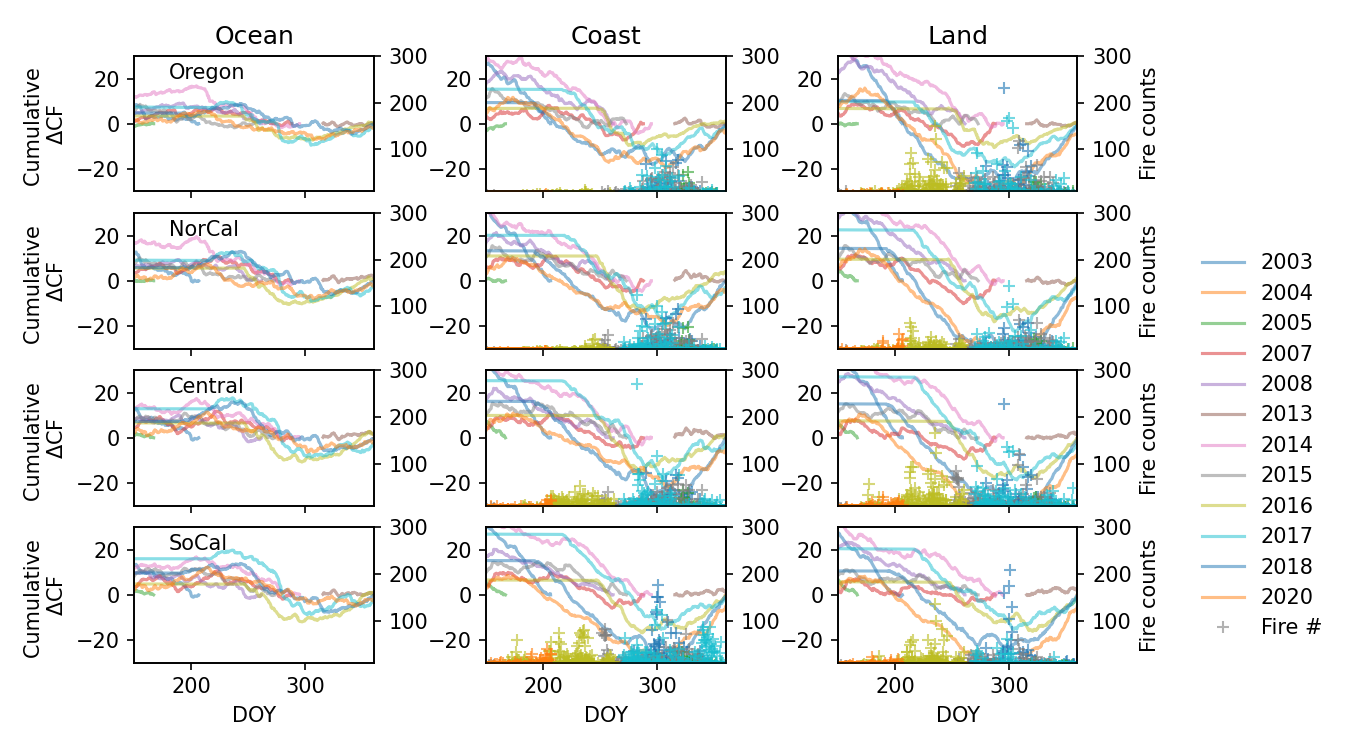

In [204]:
fig, ax = plt.subplots(4,3,figsize=(9,5.0))
for j in range(4):    
    axx = [axs.twinx() for axs in ax[j,:]]
    for i,yy in enumerate(years):
        if fir[i]:
            doyf = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in fir[i]['time']]
            fir[i]['doy'] = np.array(doyf)
        if cld[i]:
            doy = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in cld[i]['time']]
            cld[i]['doy'] = np.array(doy)

            p = ax[j,0].plot(doy,cld[i]['CF']['ocean']['dev'][:,3-j],'-',alpha=0.5,label=yy)
            ax[j,0].set_ylabel('Cumulative \n$\Delta$CF')
            #x,y = savgol_filter((doy,cld[i]['CF']['coast']['mean'][:,0]),25,3)
            #x,y = smooth_l(doy,cld[i]['CF']['coast']['mean'][:,0],1)x/
            #x,y = smooth_s(doy,cld[i]['CF']['coast']['mean'][:,0],w=125,p=3)
            #x,y = smooth_g(doy,cld[i]['CF']['ocean']['mean'][:,j],s=12.0)
            #ax[0].plot(x,y,'-',c=p[0].get_color(),label=yy)

            ax[j,1].plot(doy,cld[i]['CF']['coast']['dev'][:,3-j],'-',alpha=0.5,c=p[0].get_color(),label=yy)
            #x,y = smooth_g(doy,cld[i]['CF']['coast']['mean'][:,j],s=12.0)
            #ax[1].plot(x,y,'-',c=p[0].get_color(),label=yy)

            ax[j,2].plot(doy,cld[i]['CF']['land']['dev'][:,3-j],'-',alpha=0.5,c=p[0].get_color(),label=yy)
            if j>=3:
                ax[j,0].set_xlabel('DOY')
                ax[j,1].set_xlabel('DOY')
                ax[j,2].set_xlabel('DOY')
            else:
                ax[j,0].set_xticklabels([])
                ax[j,1].set_xticklabels([])
                ax[j,2].set_xticklabels([])
            #x,y = smooth_g(doy,cld[i]['CF']['land']['mean'][:,j],s=12.0)
            #ax[2].plot(x,y,'-',c=p[0].get_color(),label=yy)

            if fir[i]:
                
                doyf = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in fir[i]['time']]
                fir[i]['doy'] = np.array(doyf)
                #axx[0].plot(doyf,fir[i]['FP']['ocean']['num'][:,3-j],'+',alpha=0.6,c=p[0].get_color())
                axx[1].plot(doyf,fir[i]['FP']['coast']['num'][:,3-j],'+',alpha=0.6,c=p[0].get_color())
                axx[2].plot(doyf,fir[i]['FP']['land']['num'][:,3-j],'+',alpha=0.6,c=p[0].get_color())
                axx[2].set_ylabel('Fire counts')
                #x,y = smooth_g(doyf,fir[i]['FP']['ocean']['num'][:,j],s=12.0)
                #axx[0].plot(x,y,'+',c=p[0].get_color())
                #x,y = smooth_g(doyf,fir[i]['FP']['coast']['num'][:,j],s=12.0)
                #axx[1].plot(x,y,'+',c=p[0].get_color())
                #x,y = smooth_g(doyf,fir[i]['FP']['land']['num'][:,j],s=12.0)
                #axx[2].plot(x,y,'+',c=p[0].get_color())
                nul = [axs.set_ylim([10,300]) for axs in axx]

    nul = [axs.set_ylim([-30,30]) for axs in ax[j,:]]
    nul = [axs.set_xlim([150,360]) for axs in ax[j,:]]
    ax[j,0].text(180,20,txts[j])
    
    if j==2:
        ax[j,2].plot(doy[0],[0],'+',alpha=0.6,c='grey',label='Fire #')
        ax[j,2].legend(frameon=False,bbox_to_anchor=(2.1,2.0),loc=1)
    if j==0:
        ax[j,0].set_title('Ocean')
        ax[j,1].set_title('Coast')
        ax[j,2].set_title('Land')
    plt.tight_layout(rect=(0,0,0.98,1),h_pad=-10.0,w_pad=0.0)
plt.savefig(fp+'FOG2FIRE_cumCF_fire_counts.png',dpi=600,transparent=True)

In [190]:
for j in range(4):    
    for i,yy in enumerate(years):
        for t in ['ocean','coast','land']:
            if cld[i]:
                doy = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in cld[i]['time']]
                cld[i]['doy'] = np.array(doy)

                ic = (cld[i]['CF'][t]['dev'][:,3-j]<-1.0)&(cld[i]['doy']>150)
                ic2 = (cld[i]['CF'][t]['dev'][:,3-j]<-5.0)&(cld[i]['doy']>150)
                #if any(ic):print('CLD :',j,yy,'[-1]',t,doy[np.where(ic)[0][0]])
                #if any(ic2):print('CLD :',j,yy,'[-5]',t,doy[np.where(ic)[0][0]])
            if fir[i]:
                doyf = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in fir[i]['time']]
                fir[i]['doy'] = np.array(doyf)
                iff = (fir[i]['FP'][t]['num'][:,3-j]>15)&(fir[i]['doy']>150.0)
                iff2 = (fir[i]['FP'][t]['num'][:,3-j]>35)&(fir[i]['doy']>150.0)
                #if any(iff): print('FIRE:',j,yy,'.15.',t,doyf[np.where(iff)[0][0]])
                #if any(iff2): print('FIRE:',j,yy,'.35.',t,doyf[np.where(iff2)[0][0]])
                if cld[i] and any(ic) and any(iff):
                    print(j,yy,t,'cld:[-1]',doy[np.where(ic)[0][0]],'fir:[15]',doyf[np.where(iff)[0][0]],
                          'fir:[max]',doyf[np.argmax(fir[i]['FP'][t]['num'][:,3-j])])
                    if any(ic2):
                        print('.','....',t,'cld:[-5]',doy[np.where(ic2)[0][0]])
                    if any(iff2):
                        print('.','....',t,'fir:[35]',doyf[np.where(iff2)[0][0]])

0 2005 coast cld:[-1] 150.41944444444442 fir:[15] 320.8375 fir:[max] 326.87916666666666
. .... coast fir:[35] 322.8861111111111
0 2015 ocean cld:[-1] 228.41666666666666 fir:[15] 286.8875 fir:[max] 294.8486111111111
0 2015 coast cld:[-1] 234.91805555555555 fir:[15] 287.84722222222223 fir:[max] 136.84583333333333
. .... coast fir:[35] 294.8486111111111
0 2015 land cld:[-1] 238.88611111111112 fir:[15] 253.875 fir:[max] 308.87638888888887
. .... land fir:[35] 255.84722222222223
0 2016 land cld:[-1] 259.42361111111114 fir:[15] 205.84166666666667 fir:[max] 235.38472222222222
. .... land cld:[-5] 271.8902777777778
. .... land fir:[35] 212.84305555555557
0 2017 ocean cld:[-1] 276.3861111111111 fir:[15] 283.8486111111111 fir:[max] 283.8486111111111
. .... ocean cld:[-5] 277.8833333333333
. .... ocean fir:[35] 283.8486111111111
0 2017 coast cld:[-1] 247.41944444444442 fir:[15] 275.8875 fir:[max] 299.8486111111111
. .... coast cld:[-5] 276.3861111111111
. .... coast fir:[35] 286.88194444444446
0 

In [284]:
dy = [int(yy) for yy in years]

In [321]:
top_fires_doy = np.zeros((len(fir),3,4,10))+np.nan #top 10 fire days
top_fires_num = np.zeros((len(fir),3,4,10))+np.nan #top 10 fire days
for i,fi in enumerate(fir):
    for ic,c in enumerate(['ocean','coast','land']):
        for ir in range(4):
            if any(fi['FP'][c]['num'][:,ir]>0.0):
                ia = fi['FP'][c]['num'][:,ir].argsort()
                if len(ia)>0:
                    top_fires_doy[i,ic,ir,:] = np.flip(fi['doy'][ia[-10:]])
                    fnum = np.array(fi['FP'][c]['num'])
                    top_fires_num[i,ic,ir,:] = np.flip(fnum[ia[-10:],ir])

<IPython.core.display.Javascript object>


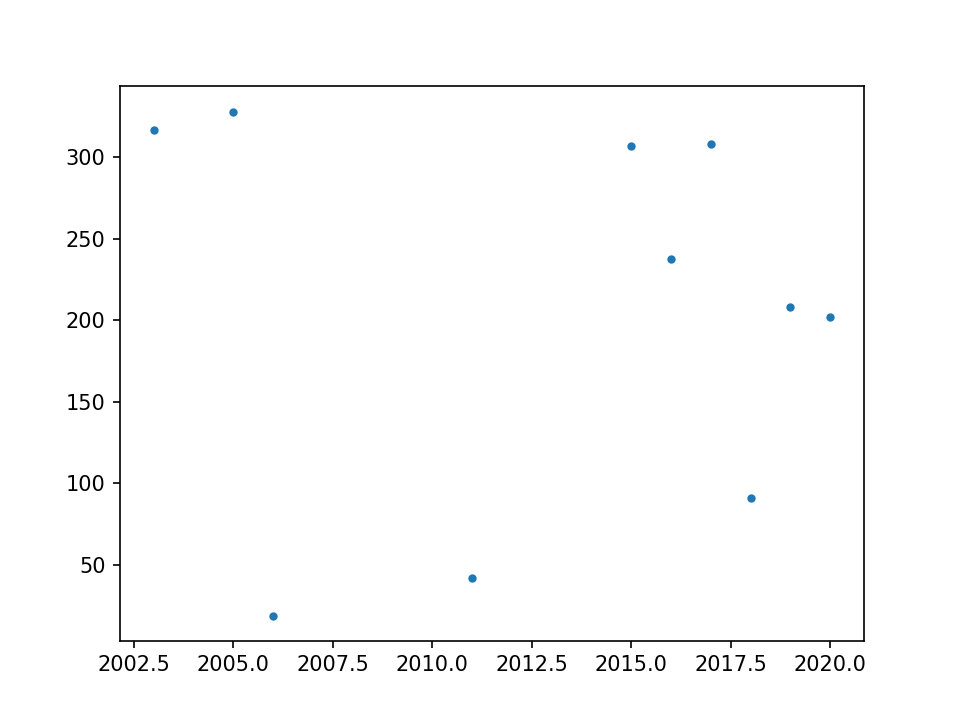

In [312]:
plt.figure()
plt.plot(dy,top_fires_doy[:,1,3,2],'.')

In [309]:
any(fi['FP'][c]['num'][:,ir]>0.0)

True

In [315]:
dy[4]

2006

<IPython.core.display.Javascript object>


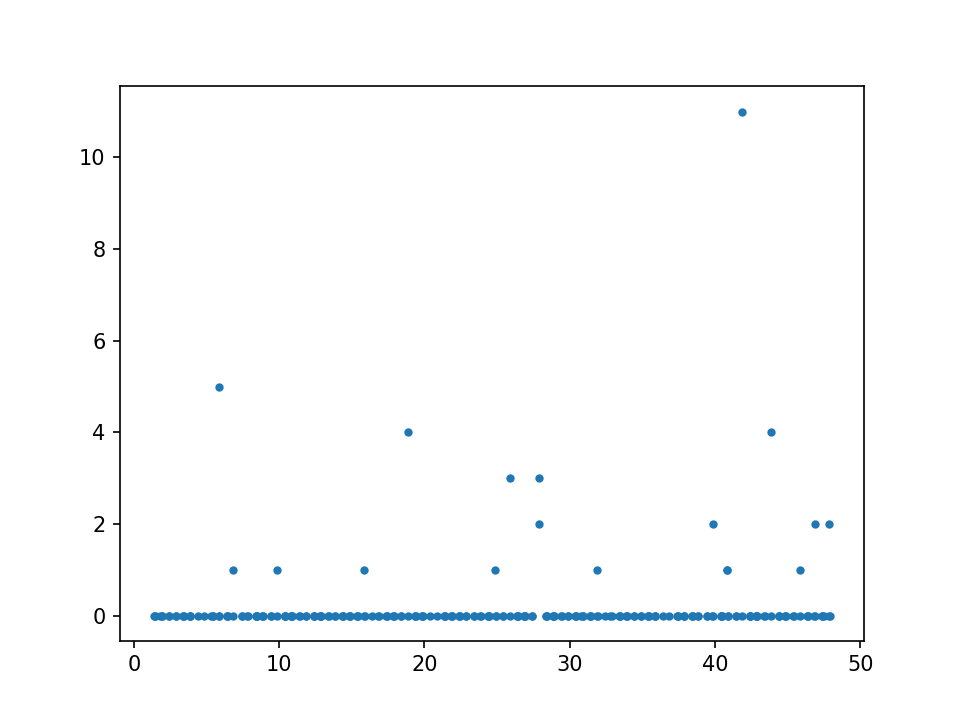

In [314]:
plt.figure()
plt.plot(fir[4]['doy'],fir[4]['FP']['coast']['num'][:,3],'.')

In [281]:
top_fires_doy

array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
      

In [234]:
from Sp_parameters import deriv, smooth
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

<IPython.core.display.Javascript object>


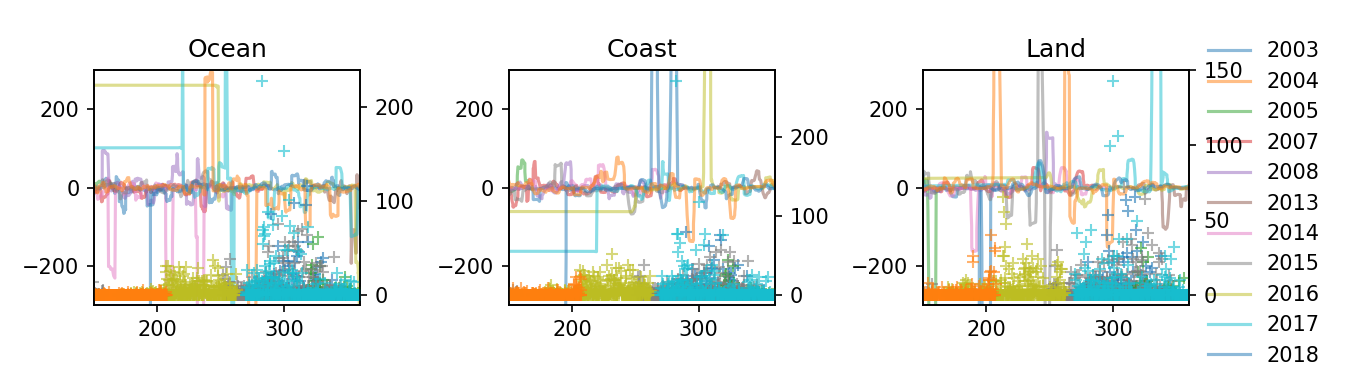

<IPython.core.display.Javascript object>


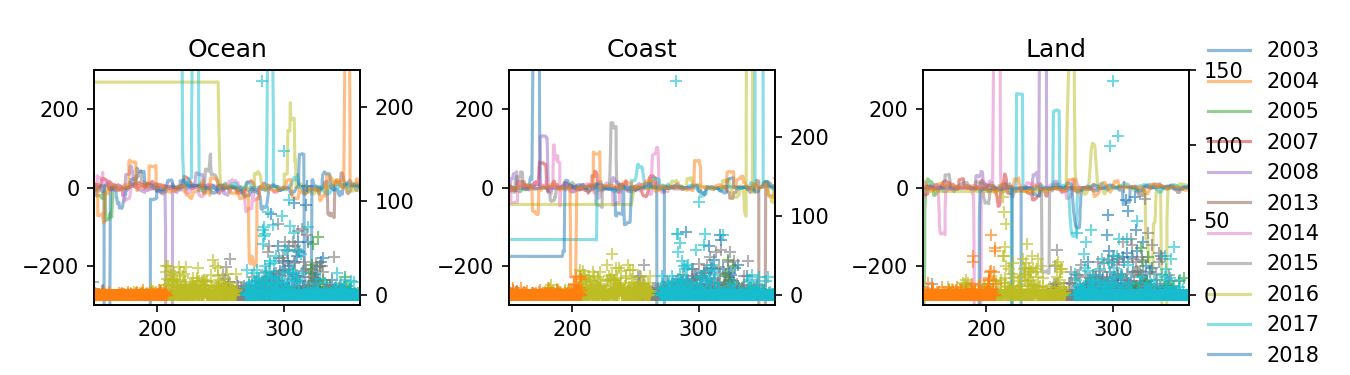

<IPython.core.display.Javascript object>


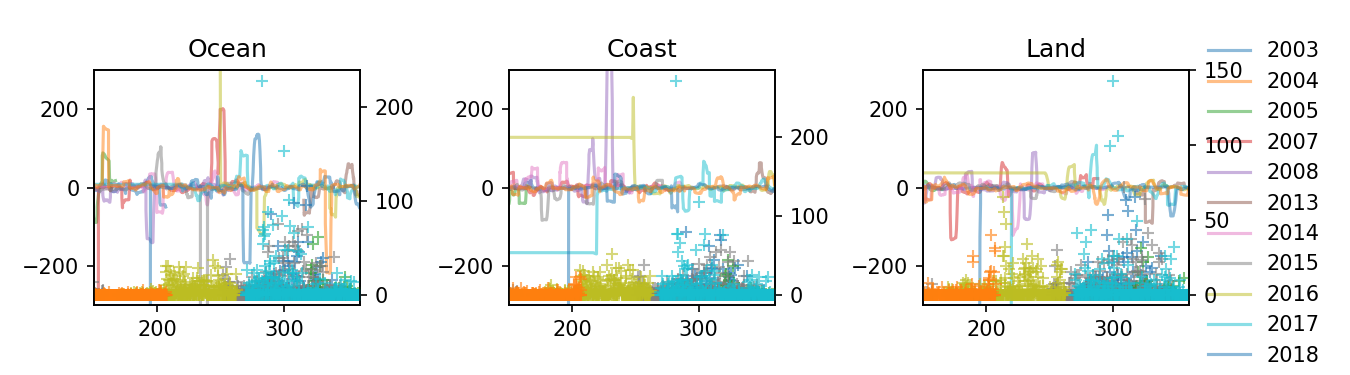

<IPython.core.display.Javascript object>


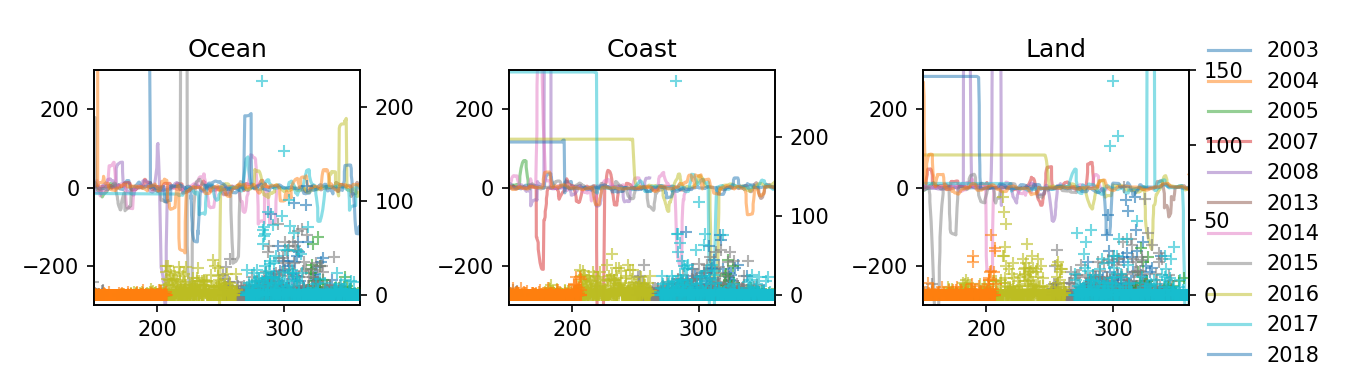

In [238]:
for j in range(4):

    fig, ax = plt.subplots(1,3,figsize=(9,2.5))
    axx = [axs.twinx() for axs in ax]
    for i,yy in enumerate(years):
        if cld[i]:
            doy = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in cld[i]['time']]

            p = ax[0].plot(doy,smooth(deriv(doy,cld[i]['CF']['ocean']['dev'][:,j]),15,old=True),'-',alpha=0.5,label=yy)
            #x,y = savgol_filter((doy,cld[i]['CF']['coast']['mean'][:,0]),25,3)
            #x,y = smooth_l(doy,cld[i]['CF']['coast']['mean'][:,0],1)
            #x,y = smooth_s(doy,cld[i]['CF']['coast']['mean'][:,0],w=125,p=3)
            #x,y = smooth_g(doy,cld[i]['CF']['ocean']['mean'][:,j],s=12.0)
            #ax[0].plot(x,y,'-',c=p[0].get_color(),label=yy)

            ax[1].plot(doy,smooth(deriv(doy,cld[i]['CF']['coast']['dev'][:,j]),15,old=True),'-',alpha=0.5,c=p[0].get_color(),label=yy)
            #x,y = smooth_g(doy,cld[i]['CF']['coast']['mean'][:,j],s=12.0)
            #ax[1].plot(x,y,'-',c=p[0].get_color(),label=yy)

            ax[2].plot(doy,smooth(deriv(doy,cld[i]['CF']['land']['dev'][:,j]),15,old=True),'-',alpha=0.5,c=p[0].get_color(),label=yy)
            #x,y = smooth_g(doy,cld[i]['CF']['land']['mean'][:,j],s=12.0)
            #ax[2].plot(x,y,'-',c=p[0].get_color(),label=yy)

            if fir[i]:
                doyf = [t.timetuple().tm_yday+t.hour/24.0+t.minute/3600.0 for t in fir[i]['time']]
                axx[0].plot(doyf,fir[i]['FP']['ocean']['num'][:,0],'+',alpha=0.6,c=p[0].get_color())
                axx[1].plot(doyf,fir[i]['FP']['coast']['num'][:,1],'+',alpha=0.6,c=p[0].get_color())
                axx[2].plot(doyf,fir[i]['FP']['land']['num'][:,2],'+',alpha=0.6,c=p[0].get_color())
                #x,y = smooth_g(doyf,fir[i]['FP']['ocean']['num'][:,j],s=12.0)
                #axx[0].plot(x,y,'+',c=p[0].get_color())
                #x,y = smooth_g(doyf,fir[i]['FP']['coast']['num'][:,j],s=12.0)
                #axx[1].plot(x,y,'+',c=p[0].get_color())
                #x,y = smooth_g(doyf,fir[i]['FP']['land']['num'][:,j],s=12.0)
                #axx[2].plot(x,y,'+',c=p[0].get_color())

    nul = [axs.set_ylim([-300,300]) for axs in ax]
    nul = [axs.set_xlim([150,360]) for axs in ax]
    ax[2].legend(frameon=False,bbox_to_anchor=(1.0,1.2) )
    ax[0].set_title('Ocean')
    ax[1].set_title('Coast')
    ax[2].set_title('Land')
    plt.tight_layout()